# CIFAR-10 Classification with CNNs
In this notebook, I explore the process of training a convolutional neural network (CNN) for image classification. I experimented with Batch Normalization and Dropout to improve generalization. The dataset used for training and evaluation is CIFAR-10.

## Setup & Imports
I start by importing PyTorch and other libraries used across the notebook as well as setting a random seed for reproducibility.
The device is set to be 'cuda', if available, for GPU optimization.

In [1]:
import torch
import pickle
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from models import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)

g = torch.Generator()
g.manual_seed(42)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Data Preparation
I load the CIFAR-10 dataset (which is split into 5 files), apply normalization, shuffle the dataset, and split it for training, validation, and testing.

In [2]:
images = np.zeros((5, 10000, 3, 32, 32), dtype=np.float32)
labels = np.zeros((5, 10000), dtype=np.int64)
for i in range(5):
    with open(f"cifar-10-batches-py/data_batch_{i+1}", 'rb') as file:
        data = pickle.load(file, encoding = 'latin1')
        images[i] = np.array(data['data']).reshape(-1, 3, 32, 32) / 255.0
        labels[i] = np.array(data['labels'])


images = images.reshape(-1, 3, 32, 32)
labels = labels.reshape(-1)

# Split the dataset
tr_images, tmp_images, tr_labels, tmp_labels = train_test_split(images, labels, train_size = 0.8, random_state = 42, stratify = labels)
dev_images, tst_images, dev_labels, tst_labels = train_test_split(tmp_images, tmp_labels, train_size = 0.5, random_state = 42, stratify = tmp_labels)

# Convert into torch tensors
tr_images = torch.from_numpy(tr_images).float()
tr_labels = torch.from_numpy(tr_labels)
dev_images = torch.from_numpy(dev_images).float()
dev_labels = torch.from_numpy(dev_labels)
tst_images = torch.from_numpy(tst_images).float()
tst_labels = torch.from_numpy(tst_labels)

# Create a dataloader for training
tr_dataset = torch.utils.data.TensorDataset(tr_images, tr_labels)
tr_dataloader = torch.utils.data.DataLoader(tr_dataset, batch_size = 128, shuffle = True, generator = g)

## Model Architecture
The model uses a series of 3 convolutional blocks followed by 2 dense layers and is declared in the "models.py" file.


### Convolutional Blocks
Each convolutional block is comprised of a convolutional layer, followed by a ReLu activation, and a max pooling layer for downsampling.
A Batch Normalization layer was later added to improve training stability, which proved effective in terms of achieving higher accuracy.
A Dropout layer was also introduced after observing a discrepancy between training and validation accuracy. The dropout rate was set empirically to 0.2, which helped reduce the gap and avoid overfitting.


### Dense Layers
The dense layers consist of two fully connected layers. The first dense layer reduces the dimensionality from the flattened convolutional block output to 216 units, followed by batch normalization, ReLU activation, and dropout, using the same intuition as before to stabilize learning and reduce overfitting. The second dense layer maps the 216 units to the 10 output classes.


## Training Setup
Below, I define the number of epochs, the optimizer, and the loss function.
The number of epochs is set to 20, to reduce overfitting. By training for a large number of epochs (e.g. 100) and monitoring the validation loss, I was able to determine at which point the model starts to overfit on the training data.
Initially, I used softmax directly in the model's forward method and paired it with negative log-likelihood loss. However, I later switched to using logits directly together with the cross-entropy loss function, and only applying softmax at inference for numerical stability during training.

In [3]:
net = Classifier(32)
net = net.to(device)
epochs = 20
optimizer = torch.optim.Adam(net.parameters(), lr = 0.001)
criterion = torch.nn.CrossEntropyLoss()

The following code is a simple training loop that uses the Adam optimizer and tracks the training and the development loss and accuracy over each epoch.
(It should take around 1 minute to run on a GPU)


In [4]:
tr_accuracies = []
tr_losses = []
dev_accuracies = []
dev_losses = []
for i in range(epochs):
    net.train()
    running_accuracy = 0.0
    running_loss = 0.0
    for j, (batch_in, labels) in enumerate(tr_dataloader):
        optimizer.zero_grad()

        batch_in = batch_in.to(device)
        labels = labels.to(device)
        
        batch_out = net(batch_in)
        loss = criterion(batch_out, labels)
        loss.backward()
        optimizer.step()

        running_accuracy += (torch.argmax(batch_out, dim = 1) == labels).float().sum().item()
        running_loss += loss.item() * batch_in.size(0)
    
    # Evaluate on development set
    net.eval()
    with torch.no_grad():
        dev_labels = dev_labels.to(device)
        dev_output = net(dev_images.to(device))
        loss = criterion(dev_output, dev_labels)
        accuracy = (torch.argmax(dev_output, dim = 1) == dev_labels).float().mean() * 100
        dev_accuracies.append(accuracy.item())
        dev_losses.append(loss.item())

    running_accuracy /= len(tr_dataloader.dataset)
    running_loss /= len(tr_dataloader.dataset)
    tr_accuracies.append(running_accuracy * 100)
    tr_losses.append(running_loss)

The graphs below showcase the training and development loss and accuracy per epoch, which were useful for measuring the performance of the model during the training phase and hyperparameter tuning during development.


               Training       Development    
Loss           0.4845         0.5541         
Accuracy (%)   82.76          81.18          



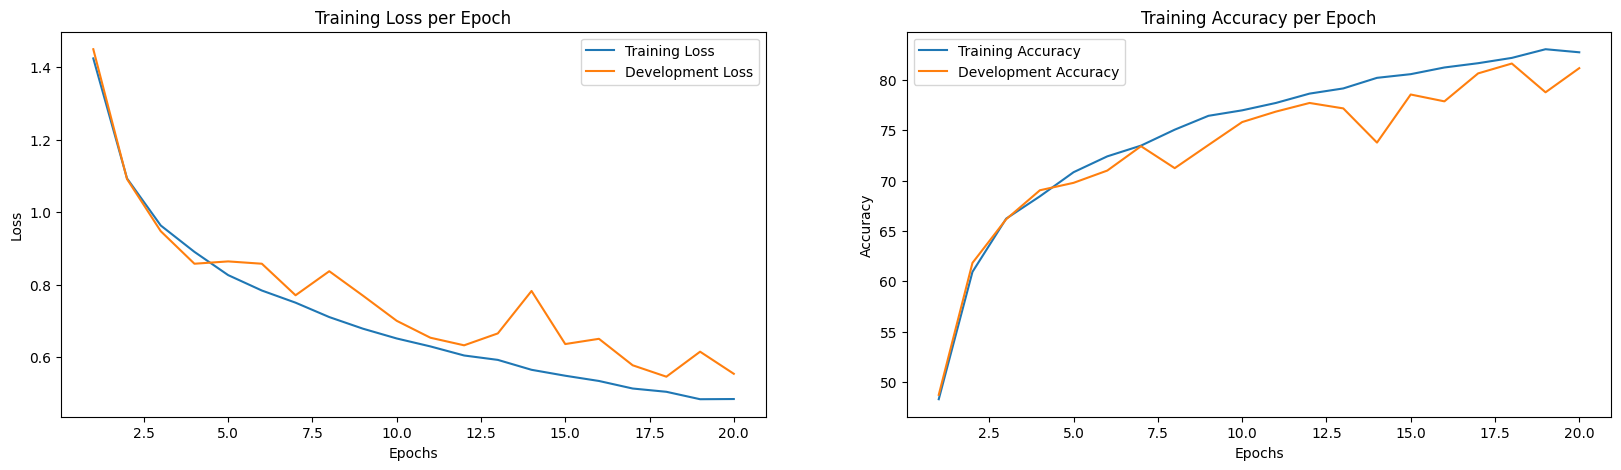

In [5]:
training_fig = plt.figure(figsize=(20, 5))

training_fig.add_subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), tr_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), dev_losses, label='Development Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.legend()

training_fig.add_subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), tr_accuracies, label='Training Accuracy')
plt.plot(range(1, epochs + 1), dev_accuracies, label='Development Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy per Epoch')
plt.legend()

print(f"\n{'':<15}{'Training':<15}{'Development':<15}")
print(f"{'Loss':<15}{tr_losses[-1]:<15.4f}{dev_losses[-1]:<15.4f}")
print(f"{'Accuracy (%)':<15}{tr_accuracies[-1]:<15.2f}{dev_accuracies[-1]:<15.2f}\n")


As seen above, the model was able to achieve an accuracy of ~83% on its training dataset and ~81% on its development dataset. The graphs only showcase the first 20 epochs because after that the training and development curves started to diverge, which is a sign of overfitting and not intended for the final classifier.
The code below displays a confusion matrix for the development dataset predictions.


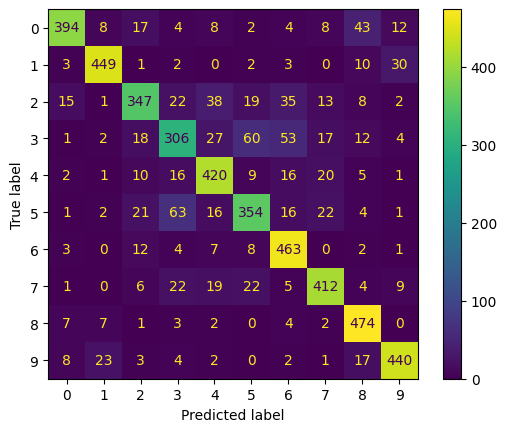

In [6]:
metrics.ConfusionMatrixDisplay.from_predictions(dev_labels.cpu(), torch.argmax(dev_output, dim = 1).cpu())

The majority of observations are classified correctly, as is observable with the bright main diagonal. It is interesting to point out that two of the classes often get mixed up by the classifier, classes 3 and 5, corresponding to the labels "cat" and "dog" respectively, when analysing the confusion matrix.
Below, I calculate important metrics, such as precision, recall and F1-score.

In [7]:
precision = metrics.precision_score(dev_labels.cpu(), torch.argmax(dev_output, dim = 1).cpu(), average=None)
recall = metrics.recall_score(dev_labels.cpu(), torch.argmax(dev_output, dim = 1).cpu(), average=None)
f1_score = metrics.f1_score(dev_labels.cpu(), torch.argmax(dev_output, dim = 1).cpu(), average=None)
print("Class\tPrecision\tRecall\tF1-Score")
for i in range(10):
    print(f"{i}\t{precision[i]:.2f}\t\t{recall[i]:.2f}\t{f1_score[i]:.2f}")

Class	Precision	Recall	F1-Score
0	0.91		0.79	0.84
1	0.91		0.90	0.90
2	0.80		0.69	0.74
3	0.69		0.61	0.65
4	0.78		0.84	0.81
5	0.74		0.71	0.73
6	0.77		0.93	0.84
7	0.83		0.82	0.83
8	0.82		0.95	0.88
9	0.88		0.88	0.88


## Conclusion
The model was able to achieve an accuracy of around 81% on a testing set, using convolutions and dense layers paired with regularization techniques, such as batch normalization and dropout, with a total of around 620K parameters.

In [8]:
trainable_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Total parameters: {trainable_params}")
net.eval()
with torch.no_grad():
    tst_labels = tst_labels.to(device)
    tst_output = net(tst_images.to(device))
    loss = criterion(tst_output, tst_labels)
    accuracy = (torch.argmax(tst_output, dim = 1) == tst_labels).float().mean() * 100

    print(f"Test Loss: {loss}")
    print(f"Test Accuracy: {accuracy}%")

Total parameters: 620842
Test Loss: 0.5548626184463501
Test Accuracy: 80.6199951171875%


In [9]:
# Save the model
torch.save(net.state_dict(), "cnn_classifier.pth")